In [172]:
import momepy
import geopandas as gpd
import numpy as np
import matplotlib.pyplot as plt
from libpysal.weights import Queen, Rook, KNN
%matplotlib inline

In [173]:
df = gpd.read_file('parcels_wdev2.shp')

In [174]:
df = df.reset_index()[['index', 'geometry']]
df = df.rename(columns={'index': 'ID'})

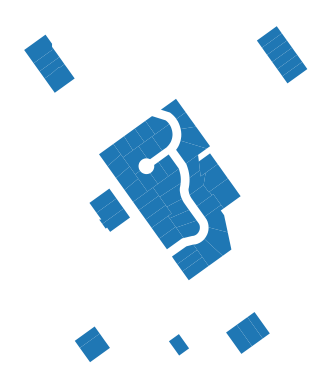

In [175]:
ax = df.plot()
ax.set_axis_off()

In [176]:
crs = df.estimate_utm_crs().to_epsg()
df = df.to_crs(crs)

# preprocess


In [177]:
#df_clean = momepy.preprocess(df, size=30,
#                              compactness=0.3, islands=True, loops=5)

In [178]:
#df_clean.plot()

# limit set at 1

In [179]:
buffer = 8

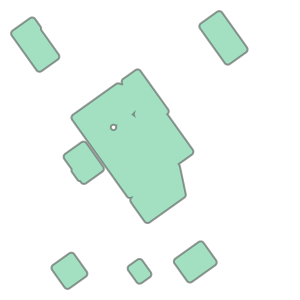

In [180]:
limit = momepy.buffered_limit(df, buffer=buffer)
limit

In [181]:
tessellation = momepy.Tessellation(df, unique_id='ID', limit=limit)

Inward offset...
Generating input point array...
Generating Voronoi diagram...
Generating GeoDataFrame...
Dissolving Voronoi polygons...


In [182]:
tessellation_gdf = tessellation.tessellation
tessellation_gdf = tessellation_gdf.reset_index(drop=True)

In [183]:
tessellation_gdf['ID'] = tessellation_gdf.index

In [184]:
tessellation_gdf.head()

,ID,geometry
0,0,"POLYGON ((481642.015 4399501.403, 481641.848 4..."
1,1,"POLYGON ((481623.221 4399636.626, 481623.292 4..."
2,2,"POLYGON ((481612.666 4399647.783, 481614.117 4..."
3,3,"POLYGON ((481598.486 4399667.146, 481601.145 4..."
4,4,"POLYGON ((481583.035 4399693.515, 481583.113 4..."


In [185]:
rook = Rook.from_dataframe(tessellation_gdf)

d:\mini-forge\envs\growth_model\Lib\site-packages\libpysal\weights\weights.py:172: UserWarning: The weights matrix is not fully connected: 
 There are 7 disconnected components.
 There is 1 island with id: 0.
  warnings.warn(message)


In [186]:
all_ids = rook.id_order
islands = rook.islands


In [187]:
# drop from gdf
#tessellation_gdf = tessellation_gdf.drop(islands)

In [188]:
#tessellation_gdf.to_file(f'tessellation_{buffer}_wdev2.shp')

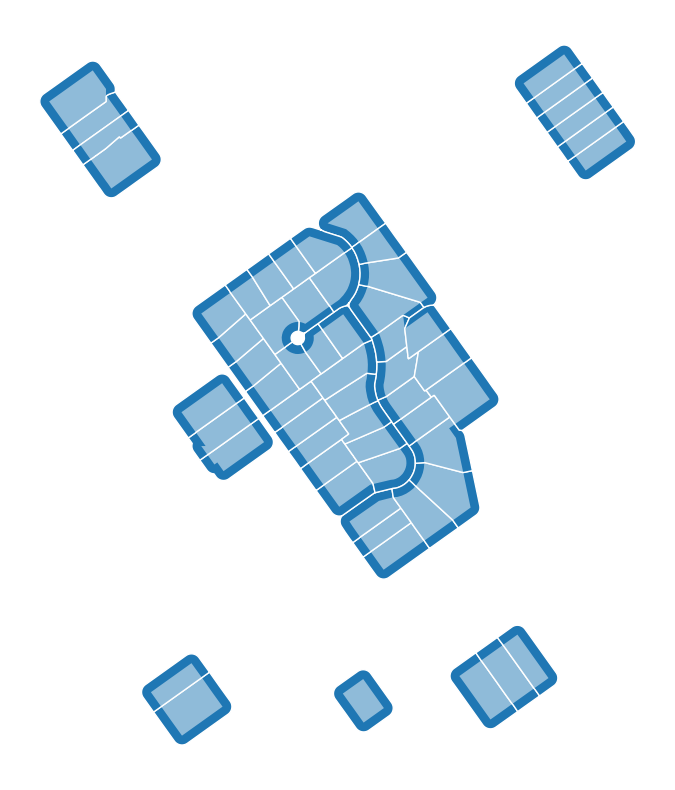

In [189]:
f, ax = plt.subplots(figsize=(10, 10))
tessellation_gdf.plot(ax=ax, edgecolor='white')
df.plot(ax=ax, color='white', alpha=.5)
ax.set_axis_off()
plt.show()

In [190]:
# remove islands from the list of all ids
all_ids = [x for x in all_ids if x not in islands]



In [191]:
for i in all_ids:
    print(f'ID: {i}: {rook.neighbors[i]}')

ID: 1: [2, 23]
ID: 2: [1, 3, 23]
ID: 3: [2, 4, 6, 23]
ID: 4: [8, 3, 5, 6]
ID: 5: [8, 4, 30, 7]
ID: 6: [3, 4, 23, 8, 24, 26, 25]
ID: 7: [9, 5, 30, 31]
ID: 8: [4, 5, 6, 26, 27, 30]
ID: 9: [32, 31, 15, 7]
ID: 10: [11]
ID: 11: [10]
ID: 12: [13]
ID: 13: [12, 14]
ID: 14: [13]
ID: 15: [16, 9, 32, 18]
ID: 16: [17, 18, 15]
ID: 17: [16, 40, 18, 19]
ID: 18: [16, 17, 33, 32, 40, 15]
ID: 19: [40, 17, 42, 41]
ID: 20: [21]
ID: 21: [20, 22]
ID: 22: [21]
ID: 23: [1, 2, 3, 6, 24]
ID: 24: [25, 6, 23]
ID: 25: [24, 26, 28, 6]
ID: 26: [6, 8, 25, 27, 28]
ID: 27: [50, 8, 26, 28, 29, 30, 31]
ID: 28: [27, 25, 50, 26]
ID: 29: [32, 34, 51, 50, 27, 31]
ID: 30: [5, 7, 8, 27, 31]
ID: 31: [32, 7, 9, 27, 29, 30]
ID: 32: [33, 34, 35, 9, 15, 18, 29, 31]
ID: 33: [32, 18, 35, 37]
ID: 34: [32, 35, 36, 51, 29]
ID: 35: [32, 33, 34, 36, 37, 38]
ID: 36: [34, 35, 52, 51, 38]
ID: 37: [33, 35, 38, 40, 44, 47]
ID: 38: [48, 35, 36, 37, 52, 53, 47]
ID: 39: [48, 53]
ID: 40: [17, 18, 19, 37, 42, 44]
ID: 41: [42, 19]
ID: 42: [40, 41, 1

In [192]:
tessellation_gdf.head()

,ID,geometry
0,0,"POLYGON ((481642.015 4399501.403, 481641.848 4..."
1,1,"POLYGON ((481623.221 4399636.626, 481623.292 4..."
2,2,"POLYGON ((481612.666 4399647.783, 481614.117 4..."
3,3,"POLYGON ((481598.486 4399667.146, 481601.145 4..."
4,4,"POLYGON ((481583.035 4399693.515, 481583.113 4..."


In [193]:
# get component labels
components = rook.component_labels

combined_polygons = tessellation_gdf.dissolve(by=components)

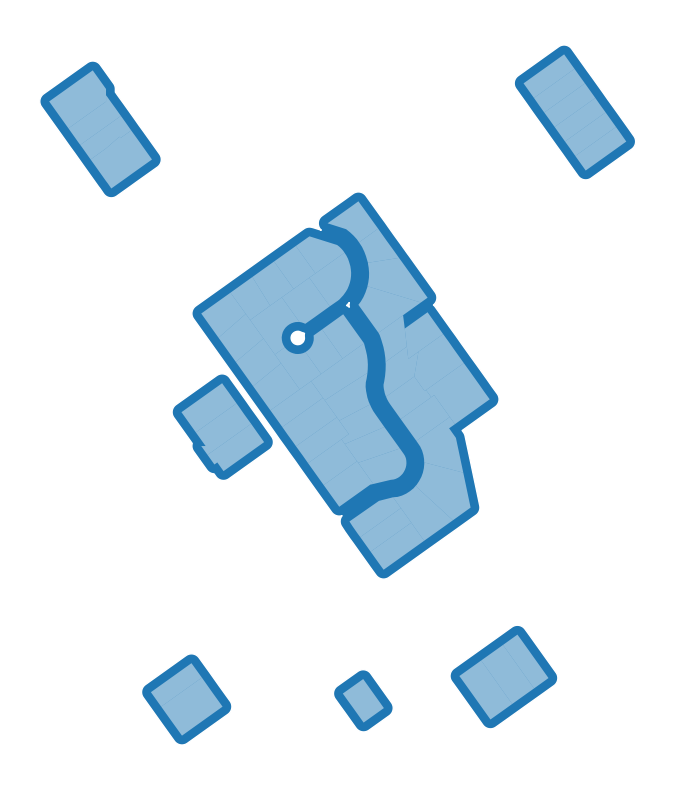

In [194]:
f, ax = plt.subplots(figsize=(10, 10))
combined_polygons.plot(ax=ax, edgecolor='white')
df.plot(ax=ax, color='white', alpha=.5)
ax.set_axis_off()
plt.show()

In [195]:
combined_polygons.to_file(f'combined_polygons_{buffer}_wdev2.shp')

In [196]:
combined_polygons_sindex = combined_polygons.sindex

In [197]:
def get_nearest(sindex, geometry):
    nearest = sindex.nearest(geometry.centroid, return_all=False, return_distance=True, max_distance=5)
    return nearest


In [198]:
def get_distance(df, offset):
    for poly in range(len(df)):
        ID = df.iloc[poly].ID
        # Calcualtes distance for each point from each df. If Point resides along edge of df( within 1-meter), distance is is given NUll then dropped
        df[f'd_to_{ID}'] = (df.apply(lambda x: 
                                                df.iloc[poly].geometry.distance(x['geometry']) 
                                                if df.iloc[poly].geometry.distance(x['geometry']) < offset 
                                                else 0, axis=1)
                                                )
    
    return df

In [199]:
combined_polygons_d = get_distance(combined_polygons, offset=5.0)

In [200]:
combined_polygons_d

,geometry,ID,d_to_0,d_to_1,d_to_10,d_to_12,d_to_20,d_to_43,d_to_54
0,"POLYGON ((481642.015 4399501.403, 481641.848 4...",0,0.0,0.000000,0.0,0.000000,0.0,0.0,0.0
1,"POLYGON ((481616.279 4399631.729, 481616.279 4...",1,0.0,0.000000,0.0,4.082984,0.0,0.0,0.0
2,"POLYGON ((481485.110 4399533.374, 481485.132 4...",10,0.0,0.000000,0.0,0.000000,0.0,0.0,0.0
3,"POLYGON ((481533.004 4399742.010, 481537.432 4...",12,0.0,4.082984,0.0,0.000000,0.0,0.0,0.0
4,"POLYGON ((481748.456 4399499.727, 481748.456 4...",20,0.0,0.000000,0.0,0.000000,0.0,0.0,0.0
5,"POLYGON ((481429.167 4399994.770, 481433.607 4...",43,0.0,0.000000,0.0,0.000000,0.0,0.0,0.0
6,"POLYGON ((481843.437 4399997.603, 481847.791 4...",54,0.0,0.000000,0.0,0.000000,0.0,0.0,0.0


In [201]:
df = combined_polygons_d